In [15]:
from pathlib import Path
import os
path = Path().absolute()

if path.name =="PCC":
    os.chdir(path.parent)

BASEDIR = Path().absolute()
BASEDIR

PosixPath('/Users/taerimyoon/toy/temp/KINN/code')

In [16]:
from utils.dataloader import get_dataset, Sampler
train_dataset,val_dataset,test_dataset,ext_dataset  = get_dataset(f"../dataset/ELASTICA.json", 1.0)

In [17]:
from utils.args import read_ARGS
configs = "PRIMNET/Elastica.py"


args = read_ARGS((BASEDIR/'configs'/configs).absolute())
args

ARGS(MODEL='PRIMNET', EVEN_JOINTS=True, WANDB=True, pname='PRIMNET_v2.2', runname='ELASTICA', DATASET='ELASTICA', TPOSE=((0, 0, 0.12),), LOAD_WEIGHTPATH=None, SAVE_PERIOD=1, TEST_PERIOD=1, EVEN_JOINT=True, p_offset_std=0.1, rpy_offset_std=0.01, axis_std=0.1, OUTPUT_NORMALIZE=False, seed=0, hdim=(16, 16), motor_embed_dim=4, lr=0.0015, lrd=0.95, wd=0.0, w_vec=0.1, epochs=2000, focus_ratio=0.2, data_ratio=1.0, n_workers=2, batch_size=64, joint_seqs=('T', 'R', 'R', 'R', 'R', 'T', 'P'), marker_num=1, motor_dim=2)

In [18]:
args.section_number = 6

In [19]:
import torch

def eye_batch(batch_size, dim = 4):
    return torch.tile(torch.eye(dim),dims=(batch_size,1,1))

In [20]:
from utils.pyart import r2t,rpy2r,pr2t, t2p

batch_size = 16

phi    = torch.ones(batch_size, args.section_number)
theta  = torch.ones(batch_size, args.section_number)
radius = torch.ones(batch_size, args.section_number)



def forward_pcc(phi, theta, radius):
    device = phi.device

    batch_size = phi.shape[0]
    section_number = phi.shape[1]
    
    outs = []
    out = eye_batch(batch_size, dim=4).to(device)

    for section in range(section_number):
        phi_ = phi[:,section]
        theta_ = theta[:,section]
        radius_ = radius[:,section]
        
        phi_rpy = torch.stack([torch.zeros_like(phi_), torch.zeros_like(phi_), phi_], dim=1)
        assert phi_rpy.shape == (batch_size,3)
        T1 = r2t(rpy2r(phi_rpy))

        theta_rpy = torch.stack([ -theta_, torch.zeros_like(-theta_), torch.zeros_like(-theta_)],dim = 1)
        assert theta_rpy.shape == (batch_size,3)
        
        P = torch.zeros(batch_size, 3, 1).to(device)
        
        assert (radius_ * (1-torch.cos(theta_))).shape == (batch_size,)
        assert (radius_ * torch.sin(theta_)).shape == (batch_size,)
        
        P[:,1,0] = radius_ * (1-torch.cos(theta_))
        P[:,2,0] = radius_ * torch.sin(theta_)
        
        T2 = pr2t(P,rpy2r(theta_rpy))
        
        T = T1@T2
        out = out @ T
        outs.append(out)
    
    outs = torch.stack(outs, dim=1)
    return outs

forward_pcc(phi,theta,radius).shape

torch.Size([16, 6, 4, 4])

In [21]:
train_sampler = Sampler(args, train_dataset)
val_sampler   = Sampler(args, val_dataset)
test_sampler  = Sampler(args, test_dataset)
ext_sampler   = Sampler(args, ext_dataset)

PI = torch.pi


In [22]:
def motor_control_to_array(motor_control):
    motor_array = torch.zeros(len(motor_control),4)

    motor_array[:,0] = torch.where(motor_control[:,0]>=0, motor_control[:,0], torch.zeros_like(motor_control[:,0]))
    motor_array[:,1] = torch.where(motor_control[:,0]<0, -motor_control[:,0], torch.zeros_like(motor_control[:,0]))

    motor_array[:,2] = torch.where(motor_control[:,1]>=0, motor_control[:,1], torch.zeros_like(motor_control[:,1]))
    motor_array[:,3] = torch.where(motor_control[:,1]<0, -motor_control[:,1], torch.zeros_like(motor_control[:,1]))

    return motor_array

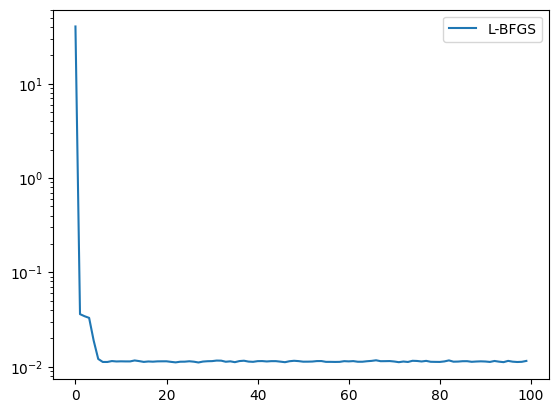

In [23]:
x = torch.tensor(.0); y = torch.tensor(.0); z = torch.tensor(.0);
L = torch.tensor(120.0)
R = torch.tensor(5.0)
d = torch.tensor(7.5)


LR = torch.tensor([L,R,d,x,y,z])
LR.requires_grad = True

from torch import optim
from torch import nn
from torch.nn import functional as F
from matplotlib import pyplot as plt
from functools import partial

optimizer = optim.LBFGS([LR],
                        history_size=10,
                        max_iter=4,
                        line_search_fn="strong_wolfe")



def p_loss_fn(x,y):
    loss =  F.l1_loss(x,y, reduction='none')
    loss = torch.mean(loss, dim=list(range(1,loss.ndim)))
    return loss

def closure(LR, motor_control):
    optimizer.zero_grad()
    pred_position = predict(LR, motor_control)
    position_loss =  p_loss_fn(pred_position, target_position[:,-1])
    
    total_loss = torch.mean(position_loss)
    total_loss.backward()
    return total_loss


def predict(LR, motor_control):
    L,R,d,x,y,z = LR
    motor_array = motor_control_to_array(motor_control)
    Lengths = torch.ones_like(motor_array)*L - motor_array/4096 * R * 2*PI
    
    l1,l3,l4,l2 = Lengths[:,0],Lengths[:,1],Lengths[:,2],Lengths[:,3]

    phi = torch.atan2((l4-l2),(l3-l1))
    theta = torch.sqrt((l3-l1)**2 + (l4-l2)**2) / (2*d)
    l = (l1+l2+l3+l4)/4
    radius = l/theta


    phi    = phi.reshape(-1,1)
    theta  = theta.reshape(-1,1)
    radius = radius.reshape(-1,1)

    phi.shape, theta.shape, radius.shape
    joint_se3 = forward_pcc(phi,theta, radius)

    EE_se3 = joint_se3[:,-1,:,:]
    pred_position = t2p(EE_se3)
    base_position = torch.stack([x,y,z]).reshape(-1,1)
    
    # assert pred_position.shape[1:] == base_position.shape
    # pred_position = pred_position + base_position
    return pred_position 


h_lbfgs = []

for i in range(100):
    for batch in train_sampler:
        target_position = batch["position"]
        motor_control = batch["motor_control"]
        
        optimizer.zero_grad()
    
    # pred_position = f(LR)
    # position_loss =  p_loss_fn(pred_position, target_position[:,-1])
    # objective = torch.mean(position_loss)
    
    
    objective = optimizer.step(partial(closure, LR, motor_control))
    h_lbfgs.append(objective.item())
    
plt.semilogy(h_lbfgs, label='L-BFGS')
plt.legend()
plt.show()

In [24]:
LR

tensor([ 0.1219,  0.5179, 12.4049,  0.0000,  0.0000,  0.0000],
       requires_grad=True)

In [25]:
pred_position = predict(LR, motor_control)
position_loss =  p_loss_fn(pred_position, target_position[:,-1])
objective = torch.mean(position_loss)
objective

tensor(0.0115, grad_fn=<MeanBackward0>)

In [26]:
for sampler in [test_sampler, ext_sampler]:

    batch = sampler.sample_all()
    motor_control = batch["motor_control"]
    target_position = batch["position"]


    with torch.no_grad():
        pred_position = predict(LR, motor_control)
        position_loss =  p_loss_fn(pred_position, target_position[:,-1])

        total_loss = torch.mean(position_loss)
        print(float(total_loss))
        

0.011555283330380917
0.021585924550890923
